In [24]:
%matplotlib inline
%pdb on
%run _547
%run _548
%run _546

np.set_printoptions(precision=2)

Automatic pdb calling has been turned ON


# quadratic cost function

Let's define an objective function using a random quadratic form,
$$J(u) = \frac{1}{2} u^T H u,$$
where $H\in\mathbb{R}^{n\times n}$ is positive-definite:  $H = H^T > 0$.

In [25]:
n = 2
np.random.seed(439)
H = PSD(n)

J = lambda u : .5 * np.dot(np.dot(u, H), u.T)

Since $J$ defines a 2D surface in 3D, we can visualize it using a contour map:

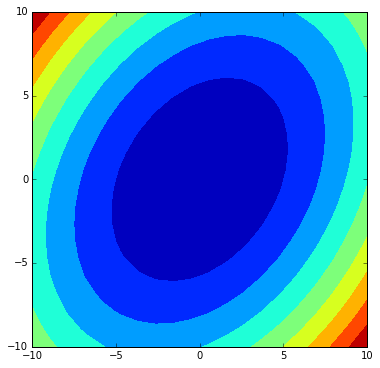

In [27]:
lim = 10.; num = 20; lims = np.asarray([-lim,lim])
_ = np.linspace(-lim,lim,num=num)
U1,U2 = np.meshgrid(_,_)
U = np.vstack([U1.flatten(),U2.flatten()]).T
JU = np.reshape(np.diag(J(U)),(num,num))

plt.figure(1,(6,6)); plt.clf(); plt.axis('equal');
plt.contourf(U1,U2,JU,levels=np.linspace(0.,J(lims),num=num/2));

# descent using derivatives

Note that the gradient and Hessian of $J$ are given by:
$$DJ(u) = u^T H,\ D^2 J(u) = H.$$

In [28]:
DJ = lambda u : np.dot(u, H)
D2J = lambda u : H

Wouldn't it be convenient if we could algorithmically obtain useful approximations for $DJ$, $D^2 J$?

Let's test finite-central-differences:

In [29]:
D??

In [30]:
u = np.asarray([np.exp(1.),np.pi])
print "u"
print u

u
[ 2.72  3.14]


In [31]:
print "DJ"
print DJ(u), 'exact'
print D(J,u), 'approx'

DJ
[ 4.23  3.72] exact
[ 4.23  3.72] approx


In [32]:
print "D^2 J"
print D2J(u), 'exact'
print D(lambda u_ : D(J,u_),u), 'approx'

D^2 J
[[ 2.28 -0.62]
 [-0.62  1.72]] exact
[[ 2.28 -0.62]
 [-0.62  1.72]] approx


In [33]:
print DJ(u) - D(J,u)
print D2J(u) - D(lambda u_ : D(J,u_),u)

[ -1.20e-11  -1.08e-11]
[[  1.11e-08  -4.05e-08]
 [ -4.05e-08  -2.08e-08]]


Wow, looks pretty good!

Let's compare their behavior when we try to compute the minimum of $J$ using Newton-Raphson:

$$u^* = u - DJ(u) (D^2J(u))^{-1}$$

In [34]:
print "Newton-Raphson iteration"
print 'u1 =',newton_raphson(u,DJ=DJ,D2J=D2J), 'exact'
print 'u1 =',newton_raphson(u,J=J), 'approx'

Newton-Raphson iteration
u1 = [ 0.  0.] exact
u1 = [  7.83e-08   1.30e-07] approx


Both good, but result using 'exact' computation is more than twice as accurate than result using 'approx'.

Let's check whether this was an artifact of the starting point we chose:

In [35]:
u0 = np.random.randn(n)
print 'u0'
print u0
print
print "Newton-Raphson iteration"
print 'exact:   J(u1) = %0.2e'%J(newton_raphson(u0,DJ=DJ,D2J=D2J))
print 'approx:  J(u1) = %0.2e'%J(newton_raphson(u0,J=J))

u0
[ 0.78 -1.98]

Newton-Raphson iteration
exact:   J(u1) = 1.40e-32
approx:  J(u1) = 5.68e-16


Looks like 'exact' is generally around twice as accurate as 'approx'.

Let's exacerbate the discrepancy by considering a poorly-scaled problem:

In [36]:
eps = 1e7
H = np.asarray([[1.,0.],[0.,eps]])
print 'H'
print H
print

J = lambda u : .5 * np.dot(np.dot(u, H), u.T)
DJ = lambda u : np.dot(u, H)
D2J = lambda u : H

u0 = lims/2.
print 'u0'
print u0
print

u_exact = [u0]; u_approx = [u0]
for k in range(4):
  u_exact.append(newton_raphson(u_exact[-1],DJ=DJ,D2J=D2J))
  u_approx.append(newton_raphson(u_approx[-1],J=J))
u_exact = np.asarray(u_exact); u_approx = np.asarray(u_approx)

print u_exact
print u_approx

H
[[  1.00e+00   0.00e+00]
 [  0.00e+00   1.00e+07]]

u0
[-5.  5.]

[[-5.  5.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ -5.00e+00   5.00e+00]
 [  1.71e+00   7.45e-08]
 [ -9.01e-10   6.62e-23]
 [  7.54e-22   6.62e-23]
 [  7.54e-22   6.62e-23]]


## Newton-Raphson 

Now let's visualize the progress of the two methods on our contour plot:

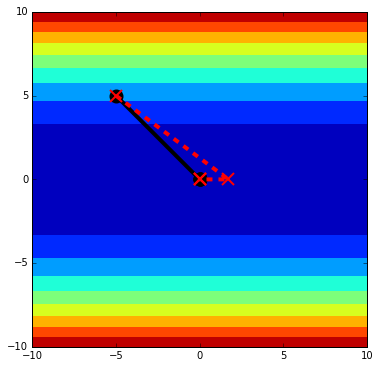

In [38]:
JU = np.reshape(np.diag(J(U)),(num,num))

plt.figure(1,(6,6)); plt.clf(); plt.axis('equal')
plt.contourf(U1,U2,JU,levels=np.linspace(0.,J(lims),num=num/2));

lw = 4; ms = 12
plt.plot(u_exact[:,0],u_exact[:,1],'ko-',lw=lw,ms=ms,mew=lw/2);
plt.plot(u_approx[:,0],u_approx[:,1],'rx--',lw=lw,ms=ms,mew=lw/2);

## steepest descent, Armijo step size

If we were being lazy and didn't want to compute the Hessian, we could try to descend using only the gradient:

$$u_{k+1} = u_k - a DJ(u)$$

where $a > 0$ is a step size parameter.

In [39]:
%run _548

H
[[  1.   0.]
 [  0.  10.]]

u0
[-5.  5.]

[[-5.    5.  ]
 [-4.16 -3.39]
 [-3.46  2.3 ]
 [-2.88 -1.56]
 [-2.4   1.05]
 [-2.   -0.71]
 [-1.66  0.48]]
[[-5.  5.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


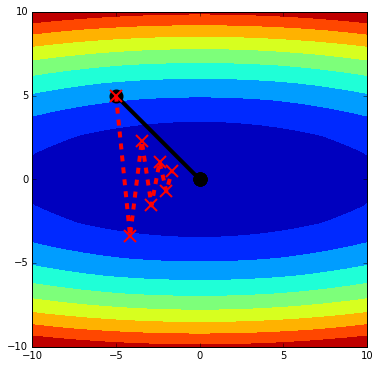

In [40]:
eps = 1e1
H = np.asarray([[1.,0.],[0.,eps]])
print 'H'
print H
print

J = lambda u : .5 * np.dot(np.dot(u, H), u.T)
DJ = lambda u : np.dot(u, H)
D2J = lambda u : H

u0 = lims/2.
print 'u0'
print u0
print

u_exact = [u0]; u_grad = [u0]
for k in range(6):
  u_grad.append(steepest_descent(u_grad[-1],J=J,DJ=DJ))
  u_exact.append(newton_raphson(u_exact[-1],DJ=DJ,D2J=D2J))
u_exact = np.asarray(u_exact); u_grad = np.asarray(u_grad);

print u_grad
print u_exact

JU = np.reshape(np.diag(J(U)),(num,num))

plt.figure(1,(6,6)); plt.clf(); plt.axis('equal')
plt.contourf(U1,U2,JU,levels=np.linspace(0.,J(lims),num=num/2));

lw = 4; ms = 12
plt.plot(u_exact[:,0],u_exact[:,1],'ko-',lw=lw,ms=ms,mew=lw/2);
plt.plot(u_grad[:,0],u_grad[:,1],'rx--',lw=lw,ms=ms,mew=lw/2);

Moving in the direction of steepest descent can cause "chattering" across narrow "valleys" of the cost landscape.  For this reason, in practice it usually pays to invest the extra effort to compute (or approximate) the Hessian.

## steepest descent, constant step size

Let's check what happens when we use a constant step size, rather than computing a step size that guarantees sufficient descent at each step (e.g. with the Armijo rule).

spec H
[  1.  10.]

step size a = 0.21


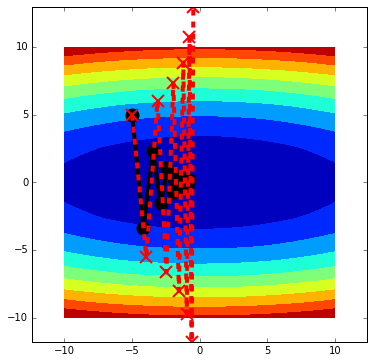

In [43]:
eps = 1e1
H = np.asarray([[1.,0.],[0.,eps]])
print 'spec H'
print np.linalg.eigvals(H)
print

a = 2.1/eps # critical value is 2 / (max spec H), i.e. 2/eps
print 'step size a =',a

J = lambda u : .5 * np.dot(np.dot(u, H), u.T)
DJ = lambda u : np.dot(u, H)

u0 = lims/2.

u_armijo = [u0]; u_const = [u0]
for k in range(10):
  u_armijo.append(steepest_descent(u_armijo[-1],J=J,DJ=DJ))
  u_const.append(steepest_descent(u_const[-1],J=J,DJ=DJ,a=lambda J,u,d : a))
u_armijo = np.asarray(u_armijo); u_const = np.asarray(u_const);

#print u_armijo
#print u_const

JU = np.reshape(np.diag(J(U)),(num,num))

plt.figure(1,(6,6)); plt.clf(); plt.axis('equal')
plt.contourf(U1,U2,JU,levels=np.linspace(0.,J(lims),num=num/2));

lw = 4; ms = 12
plt.plot(u_armijo[:,0],u_armijo[:,1],'ko-',lw=lw,ms=ms,mew=lw/2);
plt.plot(u_const[:,0],u_const[:,1],'rx--',lw=lw,ms=ms,mew=lw/2);

The critical value for the constant step size predicted by theory is $\overline{\alpha} = 2/\sigma$ where $\sigma = \max\text{spec}\ H$; sure enough, values smaller than $\overline{\alpha}$ seem to lead to convergence, whereas values larger than $\overline{\alpha}$ lead to divergence.

# derivative-free descent

In [44]:
%run _546

spec H
[  1.  10.]

smoothing parameter mu = 0.1


(-10.0, 10.0)

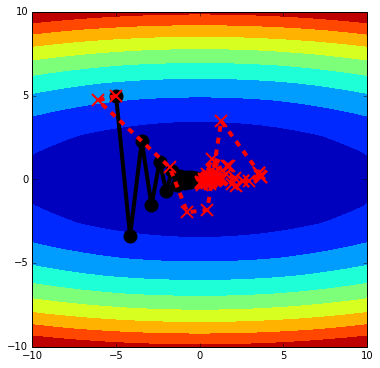

In [47]:
eps = 1e1
H = np.asarray([[1.,0.],[0.,eps]])
print 'spec H'
print np.linalg.eigvals(H)
print

mu = 1e-1
print 'smoothing parameter mu =',mu

J = lambda u : .5 * np.dot(np.dot(u, H), u.T)
DJ = lambda u : np.dot(u, H)

u0 = lims/2.

np.random.seed(439)

u_armijo = [u0]; u_zeroth = [u0]
for k in range(100):
  u_armijo.append(steepest_descent(u_armijo[-1],J=J,DJ=DJ))
  u_zeroth.append(zeroth_order(u_zeroth[-1],J=J,a=1/(eps*(1+1e-2*k)),mu=mu))
u_armijo = np.asarray(u_armijo); u_zeroth = np.asarray(u_zeroth);

#print u_armijo
#print u_zeroth

JU = np.reshape(np.diag(J(U)),(num,num))

plt.figure(1,(6,6)); plt.clf(); plt.axis('equal'); ax = plt.gca()
plt.contourf(U1,U2,JU,levels=np.linspace(0.,J(lims),num=num/2));
xlim = ax.get_xlim(); ylim = ax.get_ylim()

lw = 4; ms = 12
plt.plot(u_armijo[:,0],u_armijo[:,1],'ko-',lw=lw,ms=ms,mew=lw/2);
plt.plot(u_zeroth[:,0],u_zeroth[:,1],'rx--',lw=lw,ms=ms,mew=lw/2);
ax.set_xlim(xlim); ax.set_ylim(ylim)

With a handful of iterations, the derivative-free method doesn't appear to be making progress toward the minimum.  But as the number of iterations increases, it seems to tend toward the minimum.  Let's visualize the progress toward the minimum as a function of the number of iterations.

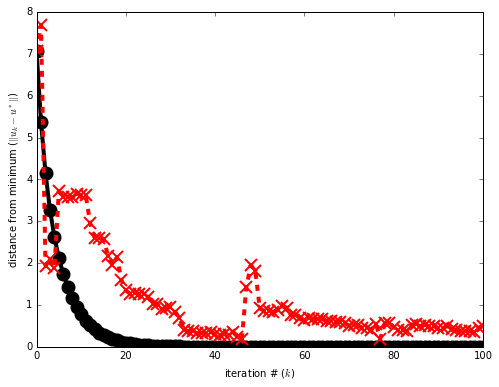

In [20]:
plt.figure(1,(8,6)); plt.clf(); ax = plt.gca()
plt.plot(np.sqrt(np.sum(u_armijo**2,axis=1)),'ko-',lw=lw,ms=ms,mew=lw/2);
plt.plot(np.sqrt(np.sum(u_zeroth**2,axis=1)),'rx--',lw=lw,ms=ms,mew=lw/2);
plt.ylabel(r'distance from minimum ($\|u_k - u^*\|$)')
plt.xlabel(r'iteration # ($k$)')

Let's rescale the $y$-axis to get a clearer picture how each algorithm is approaching the minimum.

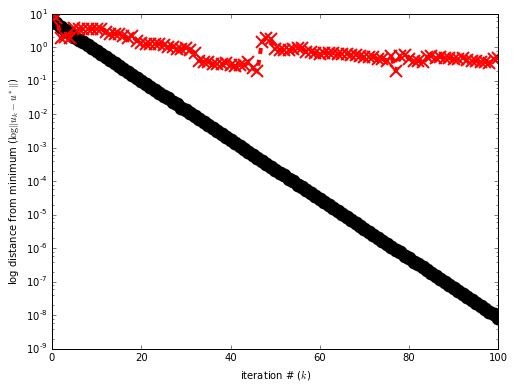

In [21]:
plt.figure(1,(8,6)); plt.clf(); ax = plt.gca()
plt.semilogy(np.sqrt(np.sum(u_armijo**2,axis=1)),'ko-',lw=lw,ms=ms,mew=lw/2);
plt.semilogy(np.sqrt(np.sum(u_zeroth**2,axis=1)),'rx--',lw=lw,ms=ms,mew=lw/2);
plt.ylabel(r'log distance from minimum ($\log\|u_k - u^*\|$)')
plt.xlabel(r'iteration # ($k$)')

The theory predicts steepest descent converges at a linear rate (slope of $-1$ on this semi-log plot), whereas the derivative-free method converges (in expectation) at a square root rate (slope of $-1/2$; see Eqn (43) in zeroth_order's citation); this seems to be (roughly) born out in this numerical experiment.

The slower convergence rate guaranteed for zeroth_order() seems to put it at a disadvantage when compared to steepest_descent().  However, zeroth_order() has two key advantages that may make it useful in some applications:

1. it doesn't require the user to compute the derivative of the cost;
2. in fact, it doesn't even require that the cost is differentiable (!)

Let's see how things work out in a simple example.

step size a = 2.0
smoothing parameter mu = 0.1


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in absolute
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in greater


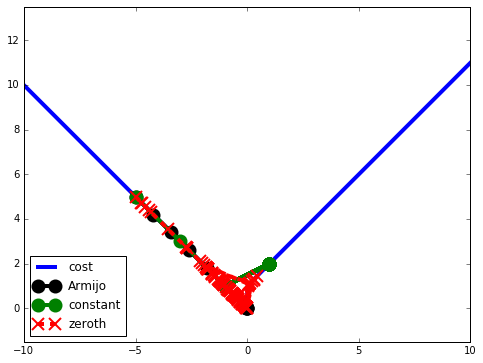

In [49]:
a = 2e0
print 'step size a =',a

mu = 1e-1
print 'smoothing parameter mu =',mu

J = lambda u : np.abs(u) # nonsmooth
J = lambda u : np.abs(u) + (u > 0) # discontinuous

u0 = lims[:1]/2.

np.random.seed(439)

u_armijo = [u0]; u_const = [u0]; u_zeroth = [u0]
for k in range(100):
  u_armijo.append(steepest_descent(u_armijo[-1],J=J))
  u_const.append(steepest_descent(u_const[-1],J=J,a=lambda J,u,d : a))
  u_zeroth.append(zeroth_order(u_zeroth[-1],J=J,a=a/(eps*(1+1e-2*k)),mu=mu))
u_armijo = np.asarray(u_armijo); u_const = np.asarray(u_const); u_zeroth = np.asarray(u_zeroth);

#print u_armijo
#print u_zeroth

U = np.linspace(lims[0],lims[1],num**2)
JU = J(U)

plt.figure(1,(8,6)); plt.clf(); plt.axis('equal'); ax = plt.gca()
plt.plot(U,JU,lw=lw,label='cost');
xlim = ax.get_xlim(); ylim = ax.get_ylim()

lw = 4; ms = 12
plt.plot(u_armijo,J(u_armijo),'ko-',lw=lw,ms=ms,mew=lw/2,label='Armijo');
plt.plot(u_const,J(u_const),'go-',lw=lw,ms=ms,mew=lw/2,mec='green',label='constant');
plt.plot(u_zeroth,J(u_zeroth),'rx--',lw=lw,ms=ms,mew=lw/2,label='zeroth');
ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.legend(loc='best')

C:\Anaconda2\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


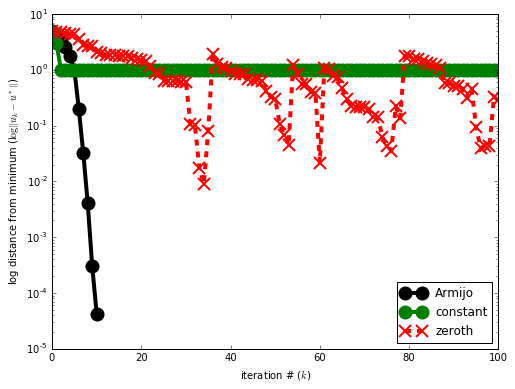

In [50]:
plt.figure(1,(8,6)); plt.clf(); ax = plt.gca()
plt.semilogy(np.sqrt(np.sum(u_armijo**2,axis=1)),'ko-',lw=lw,ms=ms,mew=lw/2,label='Armijo');
plt.semilogy(np.sqrt(np.sum(u_const**2,axis=1)),'go-',lw=lw,ms=ms,mew=lw/2,mec='green',label='constant');
plt.semilogy(np.sqrt(np.sum(u_zeroth**2,axis=1)),'rx--',lw=lw,ms=ms,mew=lw/2,label='zeroth');
plt.ylabel(r'log distance from minimum ($\log\|u_k - u^*\|$)')
plt.xlabel(r'iteration # ($k$)')
ax.legend(loc='best')

## simulated annealing (TODO)

Now let's consider a truly probabilistic algorithm that uses no local information whatsoever:  simulated annealing.  This algorithm was originally proposed and developed in the statistical mechanics community (i.e. physicists, chemists) to predict crystal structures; it's since found widespread use in optimization problems with a large number of decision variables.  One key advantage is that it can be straightforwardly applied to combinatorial problems, i.e. problems where the decision variables are drawn from a finite set.  We'll consider a variant suited to problems with continuous decision variables.